In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import coin
import yfinance as yf

In [2]:
df = yf.download('IVVB11.SA BOVA11.SA', interval='15m', period='60d')['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [3]:
df.dropna(inplace=True)

In [4]:
retorno, df_ln = coin.calc_ret_ln(df)

In [5]:
retorno

,BOVA11.SA,IVVB11.SA
Datetime,,
2021-07-19 10:00:00-03:00,-0.000836,-0.000707
2021-07-19 10:15:00-03:00,-0.002005,0.0
2021-07-19 10:30:00-03:00,0.002005,0.004293
2021-07-19 10:45:00-03:00,0.002931,-0.003294
2021-07-19 11:00:00-03:00,0.000335,-0.000375
...,...,...
2021-10-11 15:30:00-03:00,-0.000555,0.000796
2021-10-11 15:45:00-03:00,0.000647,-0.000114
2021-10-11 16:00:00-03:00,0.002222,0.001291


In [6]:
periodo = 1000
base = retorno

# Regressão

## Precos as is

In [7]:
y = np.array(base['BOVA11.SA'].iloc[:periodo], dtype = float)
x = np.array(base.iloc[:periodo,1:], dtype = float)

In [8]:
coef = coin.reg_m(x,y).params

In [9]:
print(coin.reg_m(x,y).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     149.8
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           3.41e-32
Time:                        21:35:38   Log-Likelihood:                 4849.2
No. Observations:                1000   AIC:                            -9694.
Df Residuals:                     998   BIC:                            -9685.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.809e-05      6e-05      0.468      0.6

In [ ]:
import plotly.express as px

fig = plt.figure(figsize=(30,30))
fig = px.scatter_3d(base, x='IVVB11.SA', y='BRL=X', z='BOVA11.SA')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Resíduos

In [11]:
residuos = pd.DataFrame(columns=['residuos'])
residuos['residuos'] = coin.reg_m(x,y).resid

In [12]:
coef

array([ 2.80910947e-05, -3.83441155e-01])

In [29]:
#erro_planilha = base['BOVA11.SA'] - (base['IVVB11.SA']*coef[2] + base['BRL=X']*coef[1] + coef[0])
erro_planilha = base['BOVA11.SA'] - (base['IVVB11.SA']*coef[1] + coef[0])
resi = erro_planilha
#resi = residuos['residuos']

In [30]:
coin.coint_model(resi)['ADF']

(-21.77701686878841,
 0.0,
 2,
 1675,
 {'1%': -3.434260059584829,
  '5%': -2.863267069870164,
  '10%': -2.5676894489641344},
 -15272.725255611746)

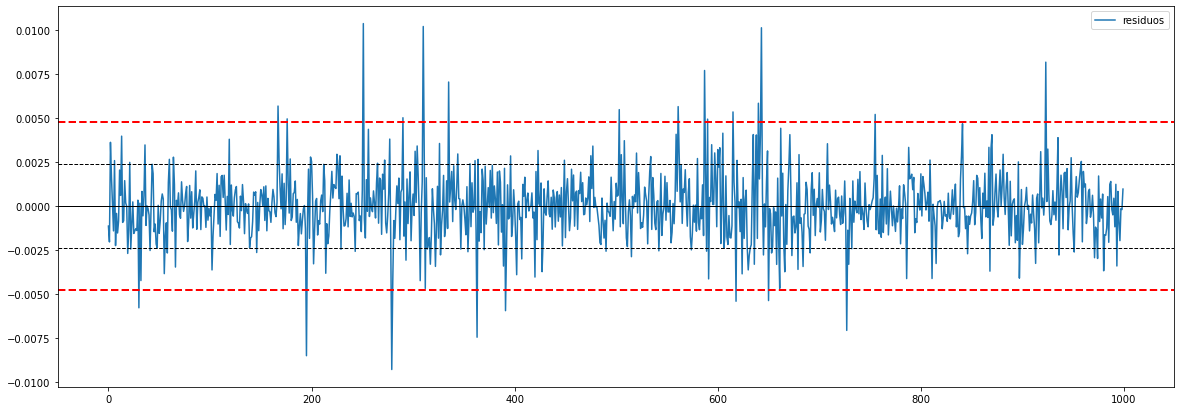

In [31]:
residuos.plot(figsize=(20,7))
plt.axhline(y=resi.std()*2, linewidth = 2, color='red', linestyle = 'dashed')
plt.axhline(y=-resi.std()*2, linewidth = 2, color='red', linestyle = 'dashed')
plt.axhline(y=resi.std(), linewidth = 1, color='black', linestyle = 'dashed')
plt.axhline(y=-resi.std(), linewidth = 1, color='black', linestyle = 'dashed')
plt.axhline(y=0, linewidth = 1, color='black')

# Meia Vida

In [17]:
half_life, ar_res, delta, lagged = coin.half_life(residuos.residuos)
print('halflife: ', half_life)

halflife:  0.7014781047304441


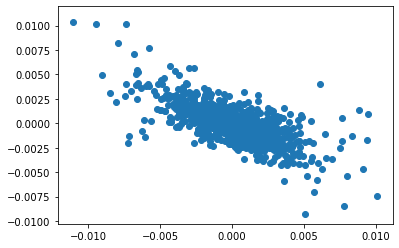

In [18]:
coin.get_scatter_plot(delta, lagged, ar_res)

## cointegrado backtest

In [ ]:
difu = dict
cointegrado = 0
amostras = 0
for inicio in range(0, 1500, 50):
    for periodo in np.arange(50,310, 10):
        y = np.array(base['BOVA11.SA'].iloc[inicio:(inicio+periodo)], dtype = float)
        x = np.array(base.iloc[inicio:(inicio+periodo),1:], dtype = float)

        residuos = pd.DataFrame(columns=['residuos'])
        residuos['residuos'] = coin.reg_m(x,y).resid
        
        test = coin.coint_model(residuos)['ADF'][0]
        difu = {'1%': -3.4753253063120644,'5%': -2.881274703275226,'10%': -2.5772928360116873}

        amostras+=1

        if difu['1%'] >= test:
            cointegrado +=1

print(cointegrado, amostras)

# Preditor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 200)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)
print(y_pred)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

In [ ]:
def resid(self):
    """The residuals of the model."""
    return self.model.endog - self.model.predict(
        self.params, self.model.exog)